In [206]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
import requests
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [207]:
df = pd.read_csv(path + './pa_fires_in_ph_clean.csv')

In [208]:
df = df.fillna(df.mean())
df = df.dropna(axis=1, how='all')


In [209]:
df['house+cooking'] = df.house_fires + df.cooking_fires
df['house+cooking_20-21'] = df['house_fires_20-21'] + df['cooking_fires_20-21']

In [210]:
target_cols = ['all_fires', 'all_fires_20-21', 'house_fires_20-21', 'cooking_fires',
               'cooking_fires_20-21', 'house_fires', 'house+cooking_20-21', 'house+cooking']
for col in target_cols:
  df[col] = df[col] > 0

In [211]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=target_cols, axis=1)
y = df['house+cooking']

In [212]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

param_dist = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None] + list(np.arange(3, 20)),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=538)

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train_resampled, y_train_resampled)

rf = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [224]:
print(random_search.best_params_)

{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 16, 'criterion': 'gini', 'bootstrap': False}


In [213]:
y_pred = rf.predict(X_test_scaled)

In [214]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.99      0.98      0.98      2145
        True       0.49      0.67      0.57        64

    accuracy                           0.97      2209
   macro avg       0.74      0.83      0.78      2209
weighted avg       0.98      0.97      0.97      2209



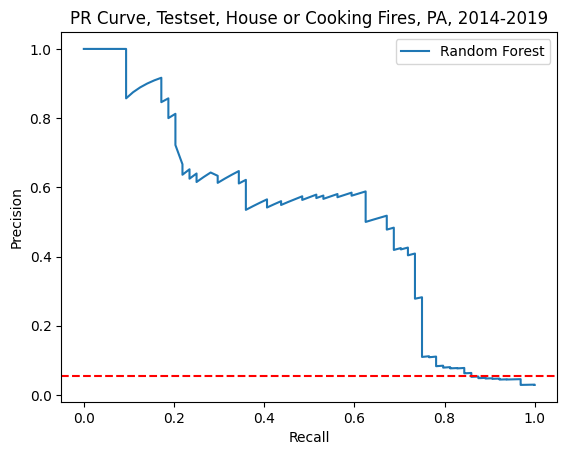

In [215]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = rf.predict_proba(X_test_scaled)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve, Testset, House or Cooking Fires, PA, 2014-2019")
plt.axhline(df.all_fires.sum() / len(df), color='r', linestyle='--')
plt.legend()
plt.show()


array([[<Axes: title={'center': '0'}>]], dtype=object)

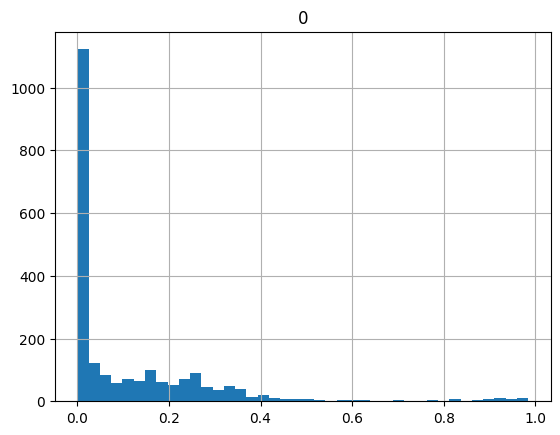

In [216]:
probabilities = rf.predict_proba(X_test_scaled)[:,1]
pd.DataFrame(probabilities).hist(bins=40)


In [217]:
feature_names = X_scaled_df.columns

importances = rf.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")


addr_type_H: 0.07969803973418553
addr_type_S: 0.05276432509986618
std_zip5: 0.048096050964139395
total_dwelling_units: 0.04255439056728403
formal_participant_name_Philadelphia Housing Authority: 0.04244672103741437
pha_total_units: 0.04092654498979409
acc_units: 0.03979160174992127
total_units: 0.03856401807558943
std_zip9: 0.037688297941625294
number_reported: 0.03721338677986314
msa_nm_Philadelphia, PA-NJ PMSA: 0.035781117334830234
total_occupied: 0.03262178842670683
construction_year: 0.032111945534372355
dofa_actual_year: 0.031237403292257812
building_type_code_WU: 0.026759556434808252
building_type_code_RW: 0.02133972021427053
msgusps: 0.01642922762653219
regular_vacant: 0.015642039041421602
pct_occupied: 0.014918539305720265
tminority: 0.013982211168432268
pct_wage_major: 0.01329955535214074
spending_per_month: 0.011447218773719856
pct_hispanic: 0.011213778623786076
spending_per_month_prev_yr: 0.009884387724175889
months_from_movein: 0.009250251750803531
building_type_code_ES: 0.

In [222]:
X_val = df.drop(columns=target_cols, axis=1)
y_val = df['house+cooking_20-21']

scaler = StandardScaler()

X_val_scaled = scaler.fit_transform(X_val)

y_pred_val = rf.predict(X_val_scaled)


              precision    recall  f1-score   support

       False       0.99      0.70      0.82     10795
        True       0.05      0.76      0.10       247

    accuracy                           0.70     11042
   macro avg       0.52      0.73      0.46     11042
weighted avg       0.97      0.70      0.81     11042



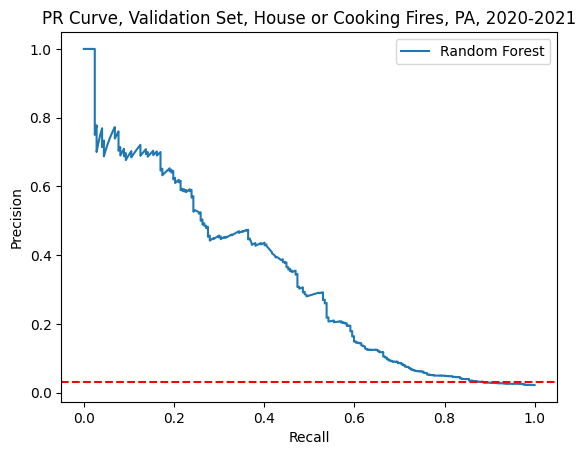

In [223]:
report = classification_report(y_val, y_pred_val)
print(report)

y_scores = rf.predict_proba(X_val_scaled)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

plt.plot(recall, precision, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve, Validation Set, House or Cooking Fires, PA, 2020-2021")
plt.axhline(df['house+cooking'].sum() / len(df), color='r', linestyle='--')
plt.legend()
plt.show()

array([[<Axes: title={'center': '0'}>]], dtype=object)

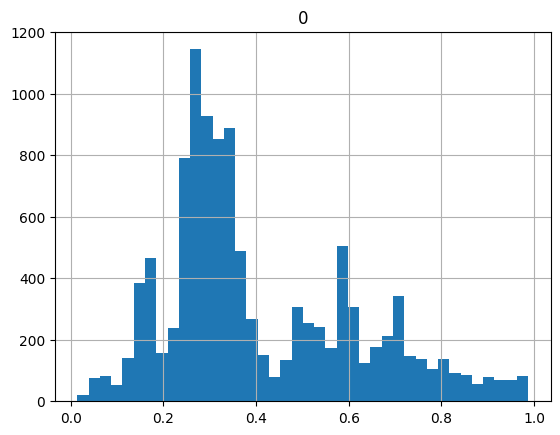

In [220]:
probabilities = rf.predict_proba(X_val_scaled)[:,1]
pd.DataFrame(probabilities).hist(bins=40)
